<a href="https://colab.research.google.com/github/msivakumar47/SIVAKUMAR-M/blob/main/k_means_project9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Running KMeans for k=2
Silhouette Score: 0.6894


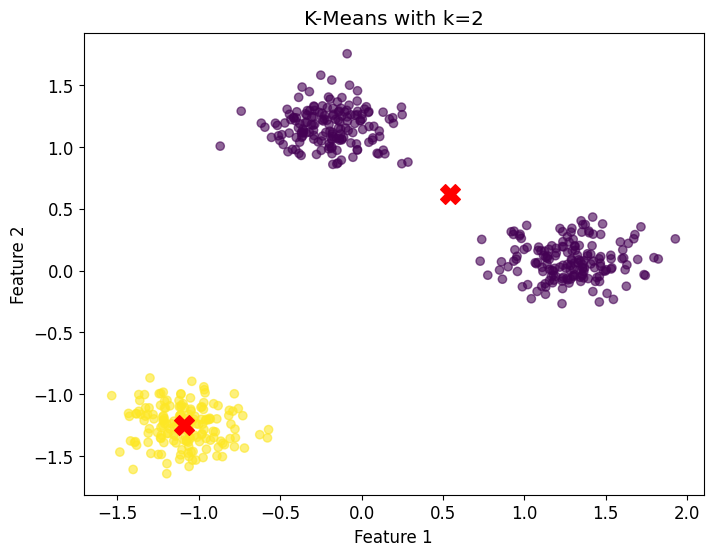


Running KMeans for k=3
Silhouette Score: 0.8448


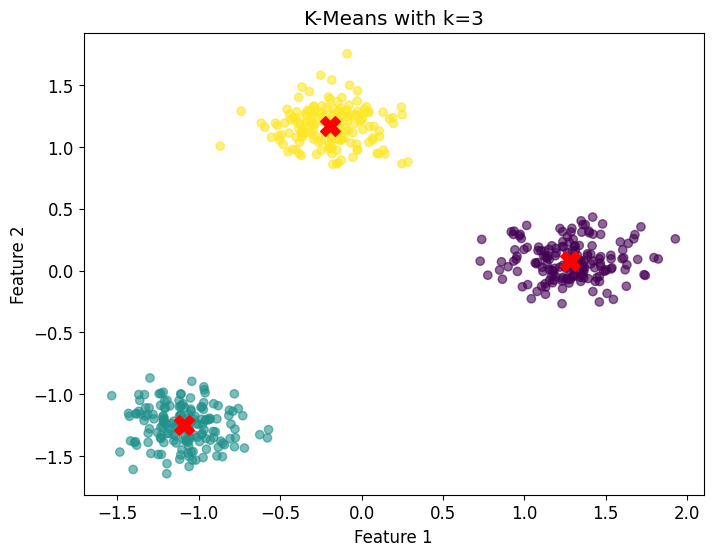


Running KMeans for k=4
Silhouette Score: 0.6855


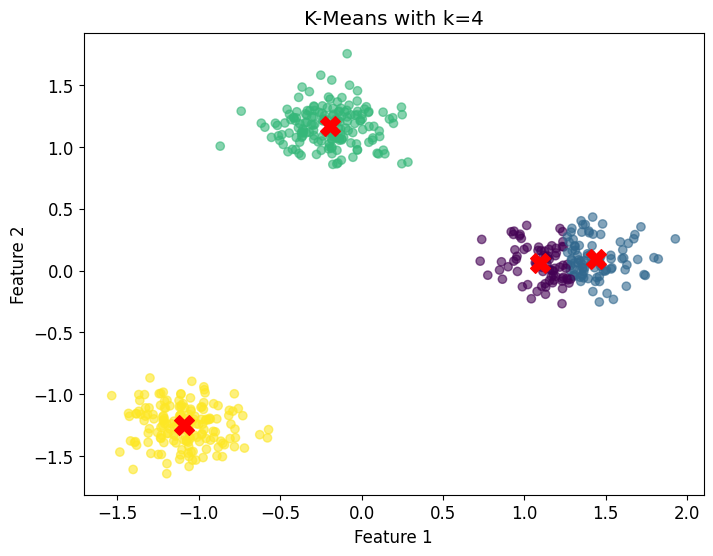

In [53]:
import numpy as np

class KMeansVectorized:
    def __init__(self, k, max_iter=300, n_init=10, tol=1e-4):
        self.k = k
        self.max_iter = max_iter
        self.n_init = n_init
        self.tol = tol
        self.centroids = None

    def _kmeans_plus_plus_init(self, X):
        n_samples = X.shape[0]
        centroids = np.empty((self.k, X.shape[1]), dtype=X.dtype)
        # Randomly choose the first centroid
        centroids[0] = X[np.random.randint(n_samples)]
        # Initialize remaining centroids
        for i in range(1, self.k):
            # Compute squared distances to nearest centroid
            dist_sq = np.min(np.square(np.linalg.norm(X[:, np.newaxis] - centroids[:i], axis=2)), axis=1)
            # Probabilities proportional to squared distances
            prob = dist_sq / dist_sq.sum()
            cumulative_prob = np.cumsum(prob)
            r = np.random.rand()
            index = np.searchsorted(cumulative_prob, r)
            centroids[i] = X[index]
        return centroids

    def fit(self, X):
        best_inertia = np.inf
        best_centroids = None
        best_labels = None

        for _ in range(self.n_init):
            centroids = self._kmeans_plus_plus_init(X)
            for iteration in range(self.max_iter):
                # Compute all distances (vectorization)
                distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
                # Assign labels
                labels = np.argmin(distances, axis=1)
                # Calculate new centroids
                new_centroids = np.zeros_like(centroids)
                for c in range(self.k):
                    cluster_points = X[labels == c]
                    if len(cluster_points) > 0:
                        new_centroids[c] = cluster_points.mean(axis=0)
                    else:
                        # Re-initialize empty cluster centroid
                        new_centroids[c] = X[np.random.randint(X.shape[0])]
                # Check convergence
                if np.allclose(centroids, new_centroids, atol=self.tol):
                    break
                centroids = new_centroids
            # Compute inertia (sum of squared distances)
            inertia = np.sum(np.min(np.square(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)), axis=1))
            if inertia < best_inertia:
                best_inertia = inertia
                best_centroids = centroids
                best_labels = labels
        self.centroids = best_centroids
        return best_labels, self.centroids

def silhouette_score_manual(X, labels):
    # Calculate silhouette score manually
    n_samples = X.shape[0]
    scores = np.zeros(n_samples)
    for i in range(n_samples):
        same_cluster = (labels == labels[i])
        other_cluster = ~same_cluster
        # A: distance to other points in cluster
        a = np.mean(np.linalg.norm(X[i] - X[same_cluster], axis=1)) if np.sum(same_cluster) > 1 else 0
        # B: distance to points in other clusters
        b_vals = []
        for label in np.unique(labels):
            if label != labels[i]:
                b_vals.append(np.mean(np.linalg.norm(X[i] - X[labels == label], axis=1)))
        b = np.min(b_vals) if b_vals else 0
        scores[i] = (b - a) / max(a, b) if max(a, b) > 0 else 0
    return np.mean(scores)

def visualize_clusters(X, labels, centroids, k):
    import matplotlib.pyplot as plt
    plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=200)
    plt.title(f'K-Means with k={k}')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.show()

# Usage example:
if __name__ == "__main__":
    from sklearn.datasets import make_blobs
    from sklearn.preprocessing import StandardScaler

    np.random.seed(42)
    X, _ = make_blobs(n_samples=500, centers=3)
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    for k in [2, 3, 4]:
        print(f"\nRunning KMeans for k={k}")
        model = KMeansVectorized(k=k, max_iter=300, n_init=10)
        labels, centroids = model.fit(X_scaled)
        score = silhouette_score_manual(X_scaled, labels)
        print(f"Silhouette Score: {score:.4f}")
        visualize_clusters(X_scaled, labels, centroids, k)
